# Multi-Class Classification with Perceptron

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pylab
import random

You can use the following perceptron training code from the lecture:

In [2]:
def train(positive_examples, negative_examples, num_iterations = 100, eta = 1):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + eta * pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - eta * neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [3]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [4]:
if not os.path.exists('mnist.pkl'):
    !wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
    !gzip -d mnist.pkl.gz

with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle, encoding='latin1')

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


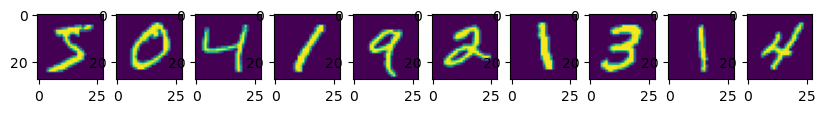

In [5]:
TRAIN, TEST = 0, 1
FEATURES, LABELS = 0, 1

print(MNIST[TRAIN][FEATURES][0][130:180])
print(MNIST[TRAIN][LABELS][0])
features = MNIST[TRAIN][FEATURES].astype(np.float32) / 256.0
labels = MNIST[TRAIN][LABELS]
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

Code to create *one-vs-other* dataset for two-digit classification. You need to modify this code to create *one-vs-all* dateset.

In [6]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j == negative_label]

    positive_images = MNIST[TRAIN][FEATURES][positive_indices]
    negative_images = MNIST[TRAIN][FEATURES][negative_indices]

    return positive_images, negative_images

Now you need to:
1. Create 10 *one-vs-all* datasets for all digits
1. Train 10 perceptrons
1. Define `classify` function to perform digit classification
1. Measure the accuracy of classification and print *confusion matrix*
1. [Optional] Create improved `classify` function that performs the classification using one matrix multiplication.